(transit)=

# Transit fitting

In [1]:
import exoplanet

exoplanet.utils.docs_setup()
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

exoplanet.__version__ = '0.5.3'


*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

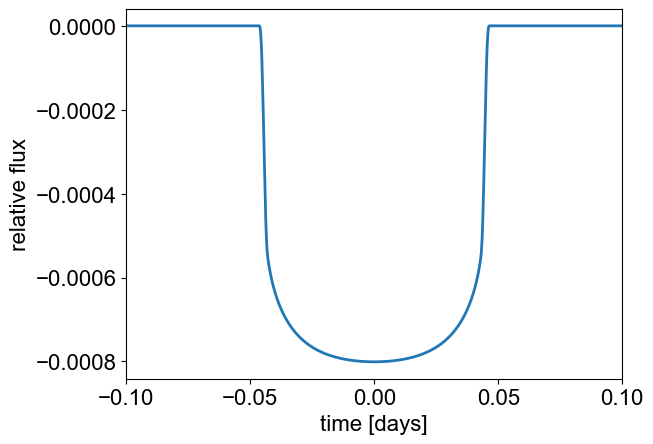

In [42]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Lucida Grande', 'Verdana']

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=1.62)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.1, 0.1, 1000)
u = [0.2, 0.3]
light_curve = (
    xo.LimbDarkLightCurve(*u)
    .get_light_curve(orbit=orbit, r=0.0266, t=t, texp=0.0011)  # Radius of the planet in solar radii (rp = 2.89 R_Earth), texp is in days
    .eval()
)
# Note: the `eval` is needed because this is using Theano in
# the background

plt.plot(t, light_curve, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())
plt.savefig("my_plot.png")

But the real power comes from the fact that this is defined as a [Aesara/Theano operation](https://aesara.readthedocs.io/en/latest/extending/index.html) so it can be combined with PyMC3 to do gradient-based inference.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [67]:
np.random.seed(123)
periods = np.random.uniform(5, 20, 2)
# t0s = periods * np.random.rand(2) # Random inital guesses for the reference transit times
t = np.arange(0, 80, 0.02)
yerr = 5e-4

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009).
This reparameterizations is implemented in *exoplanet* as custom *PyMC3* distribution :class:`exoplanet.distributions.QuadLimbDark`.

In [85]:
import pymc3 as pm
import pymc3_ext as pmx
import pandas as pd

# Load the data from the CSV file
data = pd.read_csv('TOI 3779.01_20230213_Measurements Data.xlsx - Sheet1.csv')
x = data['BJD_TDB'].values
y = data['rel_flux_T1'].values

with pm.Model() as model:
    # The baseline flux
    baseline_flux_mean_prior =  0.065375461
    baseline_flux_sd_prior =  0.013075092

    mean = pm.Normal("mean", mu=baseline_flux_mean_prior, sd=baseline_flux_sd_prior)

    
    # The time of a reference transit for the first planet
    t0_prior_mean = 2459989.7337
    t0_prior_sd = 0.015
    
    t0 = pm.Normal("t0", mu=t0_prior_mean, sd=t0_prior_sd)
    # The log period for the first planet; also tracking the period itself

    orbital_period_mean = 1.61805775970696
    orbital_period_sd = 0.000007728931
    logP = pm.Normal("logP", mu=np.log(orbital_period_mean), sd=orbital_period_sd)

    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening parameters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.2, 0.3]))

    #calculated_r_ratio = 0.08324662155  
    r = pm.Uniform("r", lower=0.01, upper=0.1, testval=0.06)  # Single planet

    
    b = xo.distributions.ImpactParameter("b", ror=r)

    
    # Set up a Keplerian orbit for the first planet
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u[0], u[1]).get_light_curve(
        orbit=orbit, r=r, t=x
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # ******************************************************************* #
    # On the following lines, we simulate the dataset that we will fit   #
    #                                                                   #
    # NOTE: if you are fitting real data, you shouldn't include this line #
    #       because you already have data!                              #
    # ******************************************************************* #
    #y = pmx.eval_in_model(light_curve)
    #y += yerr * np.random.randn(len(y))
    # ******************************************************************* #
    # End of fake data creation; you want to include the following lines  #
    # ******************************************************************* #

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    # Fit for the maximum a posteriori parameters given the simulated
    # dataset
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [b, r, u, logP, t0, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 194.60211566334388 -> 964.3365229793716


Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


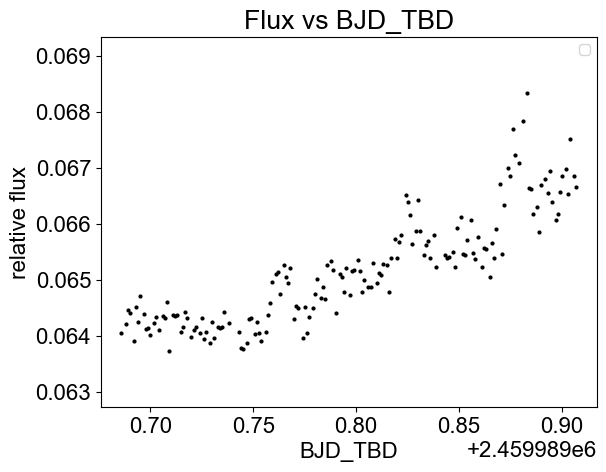

In [129]:
plt.plot(x, y, ".k", ms=4)  # Use x instead of t here
plt.xlim(x.min()-0.01, x.max()+0.01)
plt.ylim(y.min()-0.001, y.max()+0.001)
plt.ylabel("relative flux")
plt.xlabel("BJD_TBD")
plt.legend(fontsize=10)
_ = plt.title("Flux vs BJD_TBD")
plt.savefig("transit_model.png")

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use `pmx.sample` from [pymc3-ext](https://github.com/exoplanet-dev/pymc3-ext).

In [90]:
np.random.seed(42)
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, r, u, logP, t0, mean]


/Users/samueljoseph/myenv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/samueljoseph/myenv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


After sampling, it's important that we assess convergence.
We can do that using the `summary` function from `ArviZ`:

In [122]:
import arviz as az

az.summary(trace, var_names=["period", "t0", "r", "b", "u", "mean"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period,1.618,0.000,1.618,1.618,0.000,0.000,1631.0,1314.0,1.0
t0,2459989.732,0.001,2459989.730,2459989.735,0.000,0.000,1287.0,921.0,1.0
r,0.037,0.001,0.035,0.039,0.000,0.000,1947.0,1552.0,1.0
b,0.053,0.038,0.000,0.122,0.001,0.001,1995.0,991.0,1.0
u[0],0.350,0.209,0.000,0.708,0.005,0.004,1448.0,938.0,1.0
u[1],-0.050,0.175,-0.371,0.276,0.004,0.003,1682.0,1516.0,1.0
mean,0.066,0.000,0.066,0.066,0.000,0.000,1650.0,1204.0,1.0


Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

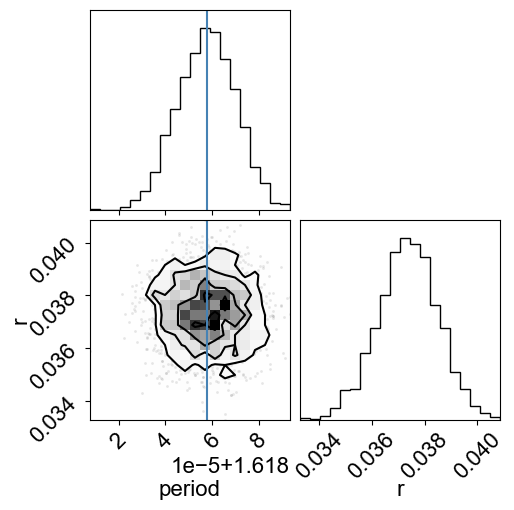

In [121]:
import corner

truth = dict(
    zip(
        ["period", "r"],
        pmx.eval_in_model([period, r], model.test_point, model=model),
    )
)
_ = corner.corner(
    trace,
    var_names=["period", "r"],
    truths=truth,
)



## Phase plots

Like in the [Radial velocity fitting](./rv.ipynb) tutorial, we can make plots of the model predictions for each planet.

[ 0.34086752  0.36086752  0.38086752  0.40086752  0.42086752  0.44086752
  0.46086752  0.48086752  0.50086752  0.52086752  0.54086752  0.56086752
  0.58086752  0.60086752  0.62086752  0.64086752  0.66086752  0.68086752
  0.70086752  0.72086752  0.74086752  0.76086752  0.78086752  0.80086752
 -0.79719145 -0.77719145 -0.75719145 -0.73719145 -0.71719145 -0.69719145
 -0.67719145 -0.65719145 -0.63719145 -0.61719145 -0.59719145 -0.57719145
 -0.55719145 -0.53719145 -0.51719145 -0.49719145 -0.47719145 -0.45719145
 -0.43719145 -0.41719145 -0.39719145 -0.37719145 -0.35719145 -0.33719145
 -0.31719145 -0.29719145 -0.27719145 -0.25719145 -0.23719145 -0.21719145
 -0.19719145 -0.17719145 -0.15719145 -0.13719145 -0.11719145 -0.09719145
 -0.07719145 -0.05719145 -0.03719145 -0.01719145  0.00280855  0.02280855
  0.04280855  0.06280855  0.08280855  0.10280855  0.12280855  0.14280855
  0.16280855  0.18280855  0.20280855  0.22280855  0.24280855  0.26280855
  0.28280855  0.30280855  0.32280855  0.34280855  0

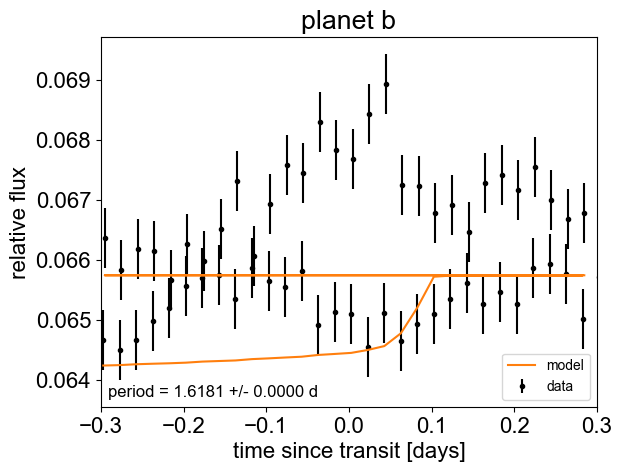

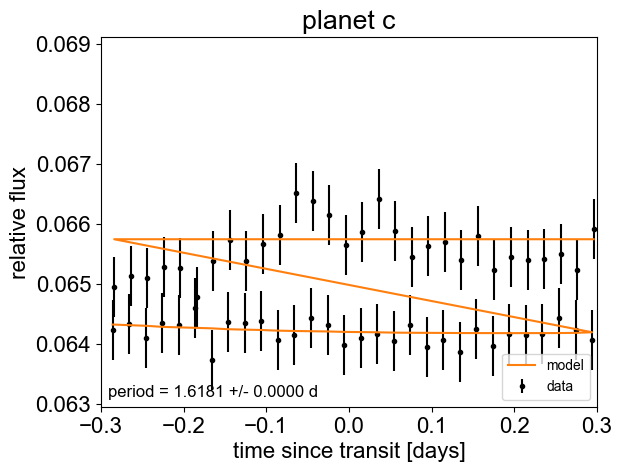

In [142]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters for the n-th planet
    period_trace = trace.posterior["period"][:, n]
    p = np.median(period_trace)
    t0 = np.median(trace.posterior["t0"][:, n])


    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    lcs = trace.posterior["light_curves"]
    other = np.median(lcs[:, :, (n + 1) % 2], axis=(0, 1))

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    

    # Ensure that x_fold and y have the same length
    min_length = min(len(x_fold), len(y))
    x_fold = x_fold[:min_length]
    y = y[:min_length]
    # Create an array of the same length as y with constant yerr value
    yerr = np.full_like(y, 5e-4)

    plt.errorbar(
    x_fold, y - other, yerr=yerr, fmt=".k", label="data", zorder=-1000
    )

    print(x_fold)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = lcs[:, :, inds, 0] + trace.posterior["mean"].values[:, :, None]
    pred = np.median(pred, axis=(0, 1))
    plt.plot(x_fold[inds], pred, color="C1", label="model")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(period_trace), np.std(period_trace)
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)


## Citations

As described in the [citation tutorial](https://docs.exoplanet.codes/en/stable/tutorials/citation/), we can use [citations.get_citations_for_model](https://docs.exoplanet.codes/en/stable/user/api/#exoplanet.citations.get_citations_for_model) to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [107]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet:joss,
exoplanet:zenodo} and its dependencies \citep{exoplanet:agol20,
exoplanet:arviz, exoplanet:astropy13, exoplanet:astropy18, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [108]:
print(bib.split("\n\n")[0] + "\n\n...")


@article{exoplanet:joss,
       author = {{Foreman-Mackey}, Daniel and {Luger}, Rodrigo and {Agol}, Eric
                and {Barclay}, Thomas and {Bouma}, Luke G. and {Brandt},
                Timothy D. and {Czekala}, Ian and {David}, Trevor J. and
                {Dong}, Jiayin and {Gilbert}, Emily A. and {Gordon}, Tyler A.
                and {Hedges}, Christina and {Hey}, Daniel R. and {Morris},
                Brett M. and {Price-Whelan}, Adrian M. and {Savel}, Arjun B.},
        title = "{exoplanet: Gradient-based probabilistic inference for
                  exoplanet data \& other astronomical time series}",
      journal = {arXiv e-prints},
         year = 2021,
        month = may,
          eid = {arXiv:2105.01994},
        pages = {arXiv:2105.01994},
archivePrefix = {arXiv},
       eprint = {2105.01994},
 primaryClass = {astro-ph.IM},
       adsurl = {https://ui.adsabs.harvard.edu/abs/2021arXiv210501994F},
      adsnote = {Provided by the SAO/NASA Astrophysics Data System